# Topic Modelling

#### Introduction

In this notebook, we conduct topic modelling (using tweet contents) on selected days where there are significant changes in prices of Bitcoin. 

We aim to see what are the topics that are being discussed during those days, and whether the topics have influenced price fluctuations. 

In [1]:
# pip install gensim

In [2]:
import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [9]:
# Read on bitcoin data and provide the percentage change on a daily basis
directory = r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Crypto_Data"
os.chdir(directory)
os.getcwd()

bitcoin = pd.read_csv("BitcoinData.csv")
doge = pd.read_csv("DogecoinData.csv")

crypto = bitcoin

crypto["Date"] = crypto.Date.astype("string")
crypto["Price"] = crypto.Price.astype("string")
crypto["Open"] = crypto.Open.astype("string")

crypto["Price"] = crypto["Price"].str.replace(",","")
crypto["Open"] = crypto["Open"].str.replace(",","")
crypto['Price'] =pd.to_numeric(crypto['Price'])
crypto['Open'] = pd.to_numeric(crypto['Open'])

crypto["Change"] = round((crypto["Price"]-crypto["Open"])/crypto["Open"] * 100,3)

# Remove the timing from Date column as it provides no useful information
# get same format as compound score file
crypto["Date"] = crypto["Date"].apply(lambda x: pd.to_datetime(x))

#change bitcoin column name to be same as the compound score files
crypto.rename(columns={'Date': 'Datetime'}, inplace= True)

crypto["Datetime"] = crypto.Datetime.astype("string")
crypto


,Datetime,Price,Open,High,Low,Vol.,Change %,Change
0,2022-04-28,40000.0,39243.0,"40,302.0","38,888.0",472.69M,1.93%,1.929
1,2022-04-27,39243.0,38113.0,"39,447.0","37,869.0",426.83M,2.96%,2.965
2,2022-04-26,38113.0,40443.0,"40,770.0","37,708.0",681.47M,-5.72%,-5.761
3,2022-04-25,40427.0,39464.0,"40,599.0","38,233.0",654.60M,2.44%,2.440
4,2022-04-24,39464.0,39434.0,"39,929.0","39,033.0",283.63M,0.12%,0.076
...,...,...,...,...,...,...,...,...
1574,2018-01-05,16954.8,15180.1,"17,126.9","14,832.4",141.96K,11.69%,11.691
1575,2018-01-04,15180.1,15156.5,"15,408.7","14,244.7",110.97K,0.15%,0.156
1576,2018-01-03,15156.6,14754.1,"15,435.0","14,579.7",106.54K,2.73%,2.728
1577,2018-01-02,14754.1,13444.9,"15,306.1","12,934.2",137.73K,9.74%,9.738


In [10]:
sd = 2.5

mean_change = crypto.describe()["Change"]['mean']
sd_change = crypto.describe()["Change"]['std']

tolerance_upper = mean_change + sd*sd_change
tolerance_lower = mean_change - sd*sd_change
print("We define days with usual price movements as {}% increase and {}% decrease".format(round(tolerance_upper,3),round(tolerance_lower,3)))

We define days with usual price movements as 10.093% increase and -9.797% decrease


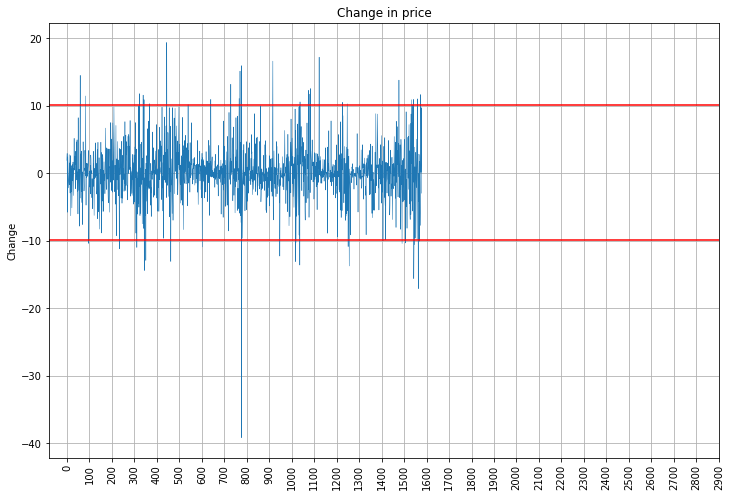

In [11]:
fig, ax1 = plt.subplots(figsize=(12,8))
graph = sns.lineplot(data = crypto, x=crypto.index, y='Change',markers = True,linewidth = 0.5)
ax1.set(title='Change in price')
plt.xticks(np.arange(0,3000,100),rotation = 90)
graph.axhline(tolerance_upper, color = "red")
graph.axhline(tolerance_lower, color = "red")
plt.grid()
plt.show()

In [12]:
unusual_dates_high = {}
unusual_dates_low = {}

for i in crypto["Change"]:
    if i>0 and i>tolerance_upper:
        unusual_dates_high[crypto["Datetime"][crypto.Change == i ].values[0]] = i
    elif i<0 and i<tolerance_lower:
        unusual_dates_low[crypto["Datetime"][crypto.Change == i ].values[0]] = i

print("Dates that have high price increase")
print(unusual_dates_high)
print("\n")
print("Dates that have large drop in price")
print(unusual_dates_low)

Dates that have high price increase
{'2022-02-28': 14.536, '2022-02-04': 11.478, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-04-26': 10.328, '2021-02-08': 19.412, '2020-11-05': 10.19, '2020-07-27': 10.975, '2020-04-29': 13.221, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-13': 15.972, '2019-10-25': 16.645, '2019-06-26': 10.601, '2019-05-19': 12.329, '2019-05-13': 11.759, '2019-05-11': 12.584, '2019-04-02': 17.23, '2018-12-20': 10.545, '2018-11-28': 10.32, '2018-04-12': 13.834, '2018-02-14': 10.93, '2018-02-12': 10.143, '2018-02-06': 10.979, '2018-01-20': 11.052, '2018-01-05': 11.691}


Dates that have large drop in price
{'2022-01-21': -10.375, '2021-09-07': -11.191, '2021-06-21': -10.972, '2021-05-19': -14.401, '2021-05-12': -12.894, '2021-01-21': -13.053, '2020-09-03': -10.903, '2020-03-12': -39.182, '2019-09-24': -12.252, '2019-07-16': -13.087, '2019-07-14': -10.244, '2019-06-27': -13.586, '2018-11-24': -10.845, '2018-11-19': -13.72, '2018-06-22':

# Sentiment Analysis of Tweets from Influencers

This section we extract tweets and process them

## Scrap Tweets from all excel file in a folder

1) Change your directory to the folder with all the excel files

2) Tweet columns scrapped are
    
    -Datetime
    
    -Tweet ID
    
    -Text
    
    -Username

In [18]:
# assign directory
directory = r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Twitter_Data\Influencer & Institutions' Tweets"
os.chdir(directory)

df_consolidated = pd.DataFrame()

# iterate over files in that directory
for filename in os.listdir(r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Twitter_Data\Influencer & Institutions' Tweets"):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df = pd.read_csv(filename)
        df_consolidated = pd.concat([df_consolidated, df],ignore_index = True)

df_consolidated

,Unnamed: 0,Datetime,Tweet Id,Text,Username
0,0,2019-01-30 23:48:18+00:00,1090758635024728069,"Jury awards Rand Paul more than $580,000 in da...",business
1,1,2019-01-30 23:37:40+00:00,1090755959029403648,Facebook investors shouldn't get lulled into a...,business
2,2,2019-01-30 23:29:19+00:00,1090753856148070401,"As Tesla bond comes due, a Chinese challenger ...",business
3,3,2019-01-30 23:23:29+00:00,1090752391304134656,Should New York City ride-share drivers get a ...,business
4,4,2019-01-30 23:20:22+00:00,1090751604972769280,"More than 1,000 confidential files somehow fou...",business
...,...,...,...,...,...
369527,311,2022-05-01 09:01:09+00:00,1520689773005877248,"@MacaesBruno Sure but as Poland shows, indepen...",VitalikButerin
369528,312,2022-05-01 08:04:08+00:00,1520675422005960704,@MacaesBruno Can you elaborate? I'm seeing lot...,VitalikButerin
369529,313,2022-05-01 04:32:24+00:00,1520622139069452289,@zengjiajun_eth The only solution is to unders...,VitalikButerin
369530,314,2022-05-01 04:31:06+00:00,1520621813209784321,@zengjiajun_eth Don't think optimizing the con...,VitalikButerin


In [19]:
# Change datetime column to string type so we can clean it

df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"] = df_consolidated["Datetime"].str[:10]
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"]

0         2019-01-30
1         2019-01-30
2         2019-01-30
3         2019-01-30
4         2019-01-30
             ...    
369527    2022-05-01
369528    2022-05-01
369529    2022-05-01
369530    2022-05-01
369531    2022-05-01
Name: Datetime, Length: 369532, dtype: string

In [20]:
#  this section we explore whether prices with high increase, have positive sentiments

print("Dates that have high price increase")
print(unusual_dates_high)

Dates that have high price increase
{'2022-02-28': 14.536, '2022-02-04': 11.478, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-04-26': 10.328, '2021-02-08': 19.412, '2020-11-05': 10.19, '2020-07-27': 10.975, '2020-04-29': 13.221, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-13': 15.972, '2019-10-25': 16.645, '2019-06-26': 10.601, '2019-05-19': 12.329, '2019-05-13': 11.759, '2019-05-11': 12.584, '2019-04-02': 17.23, '2018-12-20': 10.545, '2018-11-28': 10.32, '2018-04-12': 13.834, '2018-02-14': 10.93, '2018-02-12': 10.143, '2018-02-06': 10.979, '2018-01-20': 11.052, '2018-01-05': 11.691}


In [21]:
res = []
for i in unusual_dates_high.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_high = df_consolidated.loc[res]
df_high.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username
317145,16434,2022-02-04,1489749051054735360,"⚡️ University Hospital in Newark, New Jersey, ...",business
317146,16435,2022-02-04,1489748253730131970,Delta says the U.S. government should use a no...,business
317147,16436,2022-02-04,1489747898535489538,When Major Marshall Glenister arrived with his...,business
317148,16437,2022-02-04,1489747896698298370,Eight-in-10 are people of color. As a so-calle...,business
317149,16438,2022-02-04,1489747888330661904,The community that the hospital serves is amon...,business


In [22]:
all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_high["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])

all_tweets

['⚡️ university hospital in newark, new jersey, is understaffed and overwhelmed. troops are plugging the gaps and improving care ',
 'delta says the u.s. government should use a no-fly list — similar to the secretive database designed to prevent terrorists from boarding airline flights — to block unruly passengers from flying ',
 'when major marshall glenister arrived with his medical team on jan. 20, university’s remaining staff greeted them in the outdated lobby with cheers.   read more from  ⬇️ ',
 'eight-in-10 are people of color. as a so-called “safety net” hospital, university sees patients regardless of insurance status — up to 15% receive charity care  ',
 'the community that the hospital serves is among the most vulnerable to covid: many are essential workers, live in close quarters or multigenerational households, have underlying conditions or qualify for medicaid ',
 "hospitals are overwhelmed and understaffed after the raging omicron variant swept the u.s. over the holidays

In [23]:
# Next, we tokenize the processed tweets, to conduct our Topic Modelling. 

def is_valid_token(token):
    # keep hashtag, but not user mentions, i've retained the code for keeping user mentions
    # if ((token.startswith('#') or token.startswith('@')) and len(token) > 2):
    if (token.startswith('#') and len(token) > 2):
        return True
    # if a token contains at least two consective English letters, we assume it's a word
    if re.match(r'.*[a-z]{2,}.*', token):
        return True
    return False

tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in all_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

[['university',
  'hospital',
  'in',
  'newark',
  'new',
  'jersey',
  'is',
  'understaffed',
  'and',
  'overwhelmed',
  'troops',
  'are',
  'plugging',
  'the',
  'gaps',
  'and',
  'improving',
  'care'],
 ['delta',
  'says',
  'the',
  'government',
  'should',
  'use',
  'no-fly',
  'list',
  'similar',
  'to',
  'the',
  'secretive',
  'database',
  'designed',
  'to',
  'prevent',
  'terrorists',
  'from',
  'boarding',
  'airline',
  'flights',
  'to',
  'block',
  'unruly',
  'passengers',
  'from',
  'flying'],
 ['when',
  'major',
  'marshall',
  'glenister',
  'arrived',
  'with',
  'his',
  'medical',
  'team',
  'on',
  'jan',
  'university',
  'remaining',
  'staff',
  'greeted',
  'them',
  'in',
  'the',
  'outdated',
  'lobby',
  'with',
  'cheers',
  'read',
  'more',
  'from'],
 ['eight-in',
  'are',
  'people',
  'of',
  'color',
  'as',
  'so-called',
  'safety',
  'net',
  'hospital',
  'university',
  'sees',
  'patients',
  'regardless',
  'of',
  'insuranc

In [24]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# # stemming
stemmer = PorterStemmer()
# only perform stemming on tokens not starting with # or @
crypto_tokens = [[token if token.startswith('#') or token.startswith('@') else stemmer.stem(token) for token in doc] for doc in crypto_tokens]


# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

# Apply Topic Modeling

We will apply Latent Dirichlet Allocation (LDA) to discover topics in the documents, and use gensim

In [25]:
from gensim import corpora, models

# construct vocabulary
vocab = corpora.Dictionary(crypto_tokens)

# construct bag of words, i.e., word vecors
bow = [vocab.doc2bow(doc) for doc in crypto_tokens]

In [26]:
# build the model
n_topic = 10
lda = models.LdaModel(bow, id2word = vocab, num_topics = n_topic)

# print out each topic, where each topic is represented by top n words
print("Topics")
for i in range(n_topic):
    print(i, ':', lda.print_topic(i, topn = 5))

Topics
0 : 0.019*"trump" + 0.012*"presid" + 0.007*"donald" + 0.006*"deal" + 0.006*"minist"
1 : 0.014*"china" + 0.014*"trump" + 0.013*"new" + 0.012*"say" + 0.012*"coronaviru"
2 : 0.012*"economi" + 0.011*"year" + 0.010*"investor" + 0.007*"coronaviru" + 0.006*"trump'"
3 : 0.015*"new" + 0.010*"coronaviru" + 0.007*"top" + 0.007*"news" + 0.007*"say"
4 : 0.010*"new" + 0.009*"market" + 0.008*"billion" + 0.008*"compani" + 0.007*"year"
5 : 0.020*"trade" + 0.018*"market" + 0.017*"china" + 0.014*"war" + 0.010*"stock"
6 : 0.012*"coronaviru" + 0.008*"first" + 0.008*"say" + 0.008*"hong" + 0.007*"kong"
7 : 0.062*"de" + 0.036*"la" + 0.017*"lo" + 0.016*"en" + 0.015*"el"
8 : 0.008*"new" + 0.008*"face" + 0.007*"airport" + 0.007*"airlin" + 0.007*"stock"
9 : 0.015*"bank" + 0.014*"say" + 0.012*"want" + 0.007*"world" + 0.006*"billion"


In [28]:
# pip install wordcloud

In [29]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [30]:
res1 = []

for i in range(n_topic):
    r1 = re.findall(r"[a-z]+",lda.print_topic(i,topn = 5))
    res1.extend(r1)
res1 = " ".join(res1)
res1

'trump presid donald deal minist china trump new say coronaviru economi year investor coronaviru trump new coronaviru top news say new market billion compani year trade market china war stock coronaviru first say hong kong de la lo en el new face airport airlin stock bank say want world billion'

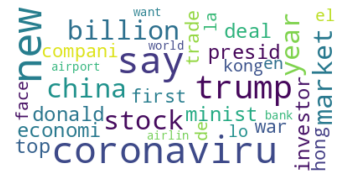

In [31]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(res1)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [95]:
# Save the image in the img folder:
wordcloud.to_file("C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\highcloud.png")

#### We will now explore topics for days with large decrease in price

In [32]:
res = []
for i in unusual_dates_low.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_low = df_consolidated.loc[res]

all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_low["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])
            
tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in all_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]


In [38]:
# construct vocabulary
vocab = corpora.Dictionary(crypto_tokens)

# construct bag of words, i.e., word vectors
bow = [vocab.doc2bow(doc) for doc in crypto_tokens]

# build the model
n_topic = 10
lda = models.LdaModel(bow, id2word = vocab, num_topics = n_topic)

# print out each topic, where each topic is represented by top n words
print("Topics")
for i in range(n_topic):
    print(i, ':', lda.print_topic(i, topn = 5))

Topics
0 : 0.016*"debate" + 0.013*"candidates" + 0.011*"new" + 0.011*"democratic" + 0.009*"first"
1 : 0.011*"#demdebate" + 0.010*"plastic" + 0.009*"first" + 0.009*"deal" + 0.008*"says"
2 : 0.015*"trump" + 0.011*"new" + 0.008*"donald" + 0.008*"candidates" + 0.008*"president"
3 : 0.011*"de" + 0.009*"here's" + 0.009*"top" + 0.009*"get" + 0.007*"growth"
4 : 0.010*"meeting" + 0.010*"democratic" + 0.010*"first" + 0.010*"among" + 0.009*"trump"
5 : 0.019*"china" + 0.016*"trump" + 0.010*"xi" + 0.010*"jinping" + 0.008*"says"
6 : 0.011*"wants" + 0.008*"brexit" + 0.008*"summit" + 0.007*"india" + 0.006*"get"
7 : 0.012*"huawei" + 0.010*"may" + 0.009*"chinese" + 0.009*"warren" + 0.009*"coverage"
8 : 0.033*"de" + 0.020*"la" + 0.019*"el" + 0.009*"se" + 0.007*"que"
9 : 0.009*"biggest" + 0.009*"coronavirus" + 0.008*"billion" + 0.007*"moment" + 0.006*"bolsonaro"


In [39]:
res2 = []

for i in range(n_topic):
    r1 = re.findall(r"[a-z]+",lda.print_topic(i,topn = 5))
    res2.extend(r1)
res2 = " ".join(res2)
res2

'debate candidates new democratic first demdebate plastic first deal says trump new donald candidates president de here s top get growth meeting democratic first among trump china trump xi jinping says wants brexit summit india get huawei may chinese warren coverage de la el se que biggest coronavirus billion moment bolsonaro'

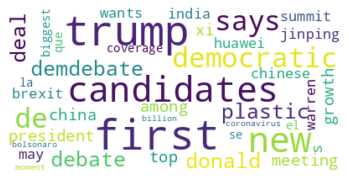

In [40]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(res2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [114]:
# Save the image in the img folder:
wordcloud.to_file("C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\lowcloud.png")

#### Conclusion

Through Topic Modelling, we found that the prices of cryptocurrencies are affected by macroeconomic factors geopolitics, and general market sentiment. Issues between countries and major economies can add uncertainty in terms of policy direction (i.e. banning of crypto farming) or amount of investments in the alternate investment space. This was cemented in the discovery of top words of topics in days with significant price decrease related to the year 2019 – 2020 China-United States trade war and recession.

With the discovery of unique topics during days with significant price decrease, it can be concluded that these were the aggravating factors being discussed on social media, that contributed to the decrease in prices of cryptocurrency. We can infer that in late 2019 and 2020, China-United States trade war was at its height, and market fears spread to crypto-markets which caused the large sell-off and the drop in cryptocurrency prices.